### Final Fine tuning with evaluation

In [1]:
import numpy as np
import pandas as pd
import torch, torchvision
import matplotlib.pyplot as plt

### loading data

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("veeralakrishna/200-bird-species-with-11788-images")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/veeralakrishna/200-bird-species-with-11788-images/versions/1


In [3]:
import tarfile
import os

# Path to the downloaded .tgz file
tgz_path = os.path.join(path, 'CUB_200_2011.tgz')

# Directory where the contents will be extracted
extract_dir = os.path.join(path, 'extracted_dataset')

# Extract the .tgz file
with tarfile.open(tgz_path, 'r:gz') as tar:
    tar.extractall(path=extract_dir)

print(f"Dataset extracted to: {extract_dir}")

Dataset extracted to: /root/.cache/kagglehub/datasets/veeralakrishna/200-bird-species-with-11788-images/versions/1/extracted_dataset


In [ ]:
image_dir = os.path.join(extract_dir,'CUB_200_2011/images')

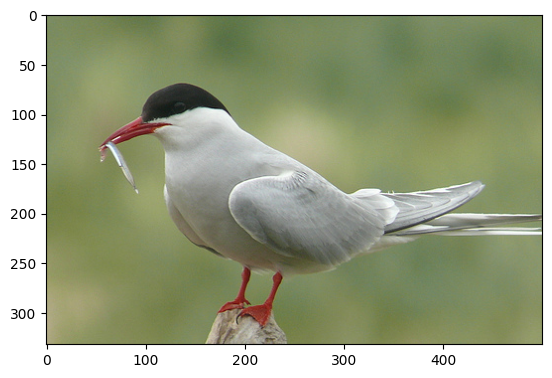

In [5]:
arctic_ten = os.path.join(image_dir, '141.Artic_Tern')
example_im = os.path.join(arctic_ten, 'Artic_Tern_0090_143583.jpg')

img = plt.imread(example_im)
plt.imshow(img)

## create the test and train data

In [6]:
image_paths = []

images = os.path.join(extract_dir,'CUB_200_2011/images.txt')
with open(images, 'r') as images_file:
  for line2 in images_file:
    image_paths.append(line2.split()[1])

print(len(image_paths))


11788


In [7]:
from torch.utils.data import random_split

In [8]:
train_datapaths, val_test_datapaths = random_split(image_paths, [int(0.7*len(image_paths)), len(image_paths)-int(0.7*len(image_paths))])

In [9]:
len(train_datapaths)

8251

In [10]:
test_datapath, val_datapaths = random_split(val_test_datapaths, [int(0.5*len(val_test_datapaths)), len(val_test_datapaths)-int(0.5*len(val_test_datapaths))])
print(len(test_datapath))
print(len(val_datapaths))

1768
1769


torch.Size([3, 333, 500])


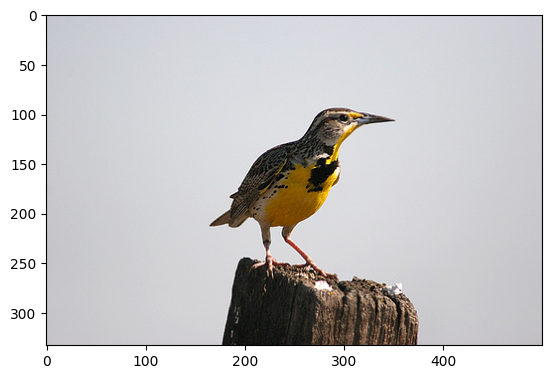

In [11]:
from torchvision.io import read_image

im = read_image(image_dir+"/"+train_datapaths[1])
print(im.shape)
plt.imshow(im.permute(1,2,0))

In [12]:
# the class of the bird species
int(train_datapaths[1].split('/')[0].split('.')[0])

88

### creating dataset class and dataloader object

In [13]:
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision import transforms

In [14]:
import albumentations as Album
from albumentations.pytorch import ToTensorV2

In [ ]:
class Bird_dataset(Dataset):
  def __init__(self, paths, transforms=None):
    super().__init__()
    self.paths = paths
    self.transform = transforms

  def __len__(self):
    return len(self.paths)

  def __getitem__(self, idx):
    image = read_image(image_dir+"/"+self.paths[idx])

    if self.transform:
      image = image.permute(1, 2, 0).numpy()
      image = self.transform(image=image)['image']

      # Ensure 3 channels after transformations
    if image.shape[0] == 1:  # If grayscale, convert to RGB
        image = image.repeat(3, 1, 1)

    label = torch.tensor(int(self.paths[idx].split('/')[0].split('.')[0])- 1)
    return image, label

### utilizing albumentations transformations

In [16]:
train_transform = Album.Compose([
    Album.HorizontalFlip(p=0.5),
    Album.RandomBrightnessContrast(p=0.2),
    Album.ShiftScaleRotate(p=0.2, shift_limit=0.05, scale_limit=0.05, rotate_limit=15),
    Album.Resize(256,256),
    Album.RandomCrop(224, 224),
    Album.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1, p=0.3),
    Album.GaussianBlur(blur_limit=(3, 7), p=0.2),
    Album.CLAHE(clip_limit=2.0, tile_grid_size=(8,8), p=0.1),
    Album.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


In [17]:
validation_transform = Album.Compose([
    Album.Resize(256, 256),
    Album.CenterCrop(height=224, width=224),
    Album.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

### creating  dataset and dataloader object

In [18]:
train_dataset = Bird_dataset(train_datapaths,transforms=train_transform)
val_dataset = Bird_dataset(val_datapaths, transforms=validation_transform)
test_dataset = Bird_dataset(test_datapath, transforms=validation_transform)


In [19]:
print(train_dataset.transform)

Compose([
  HorizontalFlip(p=0.5),
  RandomBrightnessContrast(p=0.2, brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), brightness_by_max=True, ensure_safe_range=False),
  ShiftScaleRotate(p=0.2, shift_limit_x=(-0.05, 0.05), shift_limit_y=(-0.05, 0.05), scale_limit=(-0.050000000000000044, 0.050000000000000044), rotate_limit=(-15.0, 15.0), interpolation=1, border_mode=0, fill=0.0, fill_mask=0.0, rotate_method='largest_box', mask_interpolation=0),
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
  RandomCrop(p=1.0, height=224, width=224, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
  ColorJitter(p=0.3, brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.1, 0.1)),
  GaussianBlur(p=0.2, blur_limit=(3, 7), sigma_limit=(0.5, 3.0)),
  CLAHE(p=0.1, clip_limit=(1.0, 2.0), tile_grid_size=(8, 8)),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, norma

In [20]:
print(val_dataset.transform)

Compose([
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
  CenterCrop(p=1.0, height=224, width=224, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [21]:
print(test_dataset.transform)

Compose([
  Resize(p=1.0, height=256, width=256, interpolation=1, mask_interpolation=0),
  CenterCrop(p=1.0, height=224, width=224, pad_if_needed=False, border_mode=0, fill=0.0, fill_mask=0.0, pad_position='center'),
  Normalize(p=1.0, mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, normalization='standard'),
  ToTensorV2(p=1.0, transpose_mask=False),
], p=1.0, bbox_params=None, keypoint_params=None, additional_targets={}, is_check_shapes=True)


In [22]:
train_dataloader = DataLoader(train_dataset, batch_size= 64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size= 64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size= 64, shuffle=True)

In [23]:
train_dataset[1][1] +1

tensor(88)

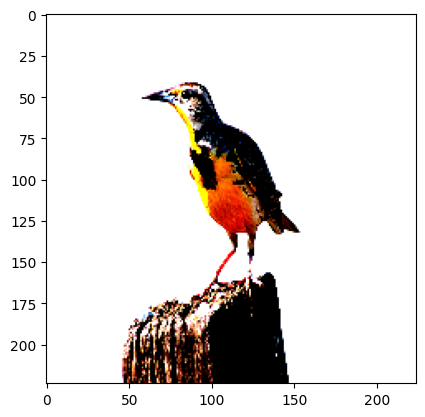

In [24]:
plt.imshow(train_dataset[1][0].permute(1,2,0))

In [25]:
train_dataset[1][0]

tensor([[[0.3652, 0.4337, 0.3652,  ..., 0.3994, 0.3823, 0.3994],
         [0.3823, 0.3994, 0.3823,  ..., 0.3994, 0.3823, 0.3994],
         [0.3994, 0.3652, 0.3823,  ..., 0.4508, 0.3994, 0.3994],
         ...,
         [0.3823, 0.3652, 0.3994,  ..., 0.3138, 0.3138, 0.3138],
         [0.3652, 0.3823, 0.3652,  ..., 0.3138, 0.2967, 0.3138],
         [0.3652, 0.3994, 0.3994,  ..., 0.3138, 0.2967, 0.3138]],

        [[0.5553, 0.5728, 0.5378,  ..., 0.5553, 0.5728, 0.5553],
         [0.5378, 0.5553, 0.5553,  ..., 0.5553, 0.5903, 0.5553],
         [0.5553, 0.5553, 0.5553,  ..., 0.5903, 0.5903, 0.5728],
         ...,
         [0.5203, 0.5028, 0.5203,  ..., 0.4503, 0.4153, 0.4328],
         [0.5028, 0.5028, 0.5028,  ..., 0.4503, 0.4328, 0.4328],
         [0.5028, 0.5378, 0.5378,  ..., 0.4503, 0.4328, 0.4153]],

        [[0.8448, 0.8448, 0.8099,  ..., 0.8622, 0.8448, 0.8797],
         [0.8448, 0.8448, 0.8448,  ..., 0.8622, 0.8622, 0.8797],
         [0.8797, 0.8448, 0.8622,  ..., 0.8797, 0.8448, 0.

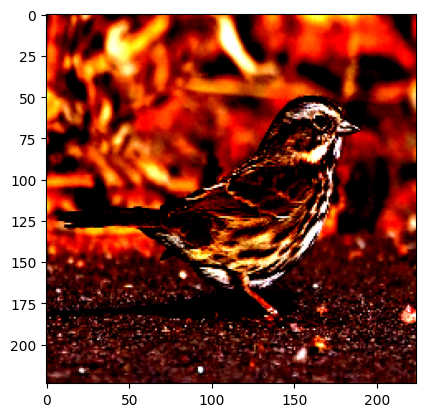

In [26]:
plt.imshow(val_dataset[1][0].permute(1,2,0))

In [27]:
val_dataset[1][1]+1

tensor(127)

In [28]:
for x in train_dataloader:
  print(x[0].shape)
  break

torch.Size([64, 3, 224, 224])


### Using mobilenet_v2 as pretrained model

In [29]:
import torchvision.models as models
import torch.nn as nn

In [30]:
model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

In [31]:
# Freeze all layers except the classifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True

for layer in model.features[13:]:
    for param in layer.parameters():
        param.requires_grad = True


In [32]:
model.classifier = nn.Sequential(
    nn.Dropout(0.3, inplace=False),
    nn.Linear(model.last_channel, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(inplace=True),
    nn.Dropout(0.3, inplace=False),
    nn.Linear(512, 200)
)

### training loop

In [33]:
from torch.optim import AdamW
from tqdm import tqdm

In [41]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.2)
optimizer = AdamW([
    {'params': model.features[13:].parameters(),  'weight_decay': 7e-5},
    {'params': model.classifier.parameters(), 'weight_decay': 7e-4},
])

In [43]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3) # Reduce LR if val loss plateaus

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [44]:
state_dict = torch.load('weights/smodel_r2.pth')

model.load_state_dict(state_dict)
model.train()

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

utilize early stopping to prevent overfitting

In [45]:
best_val_acc = 0
patience = 3
min_delta = 0.005
for epoch in range(18):
  total_correct_train = 0  # Accumulate correct predictions for training
  total_samples_train = 0  # Accumulate total samples for training

  for x, y in tqdm(train_dataloader):
    x = x.to(device)
    y = y.to(device)
    y_pred = model.forward(x)

    predicted_labels = y_pred.argmax(dim=1)
    total_correct_train += (predicted_labels == y).sum().item()  # Add correct predictions
    total_samples_train += len(y)  # Add total samples in the batch

    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  train_accuracy = total_correct_train / total_samples_train
  with torch.no_grad():
    acc = []
    for x, y in val_dataloader:
      x = x.to(device)
      y = y.to(device)
      y_pred = model.forward(x).argmax(-1)
      acc.append((y_pred == y).sum().item()/len(y))
  print("epoch:", epoch," loss:",loss.item(), "acc:",np.mean(acc), "training acc:", train_accuracy)

  # early stopping
  if np.mean(acc) > best_val_acc and np.mean(acc)-best_val_acc> min_delta:
    best_val_acc = np.mean(acc)
    patience = 3
    torch.save(model.state_dict(), 'weights/best_smodel_r2.pth')
  else:
    patience -= 1
    if patience == 0:
      print("Early stopping triggered")
      break
  scheduler.step(loss)

100%|██████████| 129/129 [00:46<00:00,  2.76it/s]


epoch: 0  loss: 1.860994577407837 acc: 0.9496406794425087 training acc: 0.9243728032965701


100%|██████████| 129/129 [00:46<00:00,  2.78it/s]


epoch: 1  loss: 1.7550972700119019 acc: 0.9441283754355402 training acc: 0.9377045206641619


100%|██████████| 129/129 [00:46<00:00,  2.75it/s]


epoch: 2  loss: 1.8788143396377563 acc: 0.9399090810104529 training acc: 0.9504302508786814


100%|██████████| 129/129 [00:46<00:00,  2.75it/s]


epoch: 3  loss: 1.9861869812011719 acc: 0.9293064024390244 training acc: 0.9527330020603563
Early stopping triggered


highest seen accuracy is 94.9% on validation with 92% on training. accuracy has been fluctuating coudl show potential problem sof overfitting

In [47]:
model.eval()
with torch.no_grad():
    acc = []
    total_loss = 0
    criterion = torch.nn.CrossEntropyLoss()

    for inputs, labels in test_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)
        total_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        accuracy = (predicted == labels).float().mean().item()
        acc.append(accuracy)

    avg_loss = total_loss / len(test_dataloader)
    avg_acc = sum(acc) / len(acc)

print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {avg_acc:.4f}")

Test Loss: 0.4066, Test Accuracy: 0.9515
